In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
colors = sns.color_palette(as_cmap=True)

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

In [4]:
SAMPLE_SPREADSHEET_ID = "1Vy4DplZAUlB0KENHUKb4A95aSNM5w7ezm2Vnl3qAG6s"
SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']
creds = Credentials.from_authorized_user_file('/n/fs/nlp-mengzhou/space3/hf/auth/token.json', SCOPES)
service = build('sheets', 'v4', credentials=creds)
sheet = service.spreadsheets()

In [5]:
def get_results(data_range):
    result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID, range=data_range).execute()
    data = np.array(result["values"])
    data = np.stack([pd.to_numeric(d, errors='coerce') for d in data])
    return data

In [6]:
def get_range(task, i):
    if task == "mnli":
        last_col = "T"
    else:
        last_col = "N"
    if i == 0:
        return f"fewshot-{task}!C4:{last_col}12"
    elif i == 1:
        return f"fewshot-{task}!C16:{last_col}24"
    elif i == 2:
        return f"fewshot-{task}!C28:{last_col}36"
    else:
        return f"fewshot-{task}!C40:{last_col}48"

In [7]:
def get_range_v2(task):
    if task == "sst2":
        return f"raw-fewshot-v2!C3:F15"
    elif task == "sst5":
        return f"raw-fewshot-v2!G3:J12"
    elif task == "mr":
        return f"raw-fewshot-v2!K3:N15"
    elif task == "mnli":
        return f"raw-fewshot-v2!C19:F31"
    elif task == "snli":
        return f"raw-fewshot-v2!K19:N31"
    elif task == "qnli":
        return f"raw-fewshot-v2!S19:V31"
    elif task == "boolq":
        return f"raw-fewshot-v2!C35:F47"
    elif task == "agnews":
        return f"raw-fewshot-v2!G35:J47"
    elif task == "rte":
        return f"raw-fewshot-v2!O19:R28"

In [8]:
def process_data(task, data):
    def get_k(i):
        if i < 4:
            return 16
        elif i < 7:
            return 32
        elif i < 10:
            return 256
        else:
            return 1024
    def get_model(i):
        if i in [0, 4, 7, 10]:
            return "bert"
        elif i in [1, 5, 8, 11]:
            return "roberta"
        elif i in [2]:
            return "roberta-large"
        else:
            return "electra"
    def get_type(j):
        if j == 0:
            return "standard_FT"
        else:
            return "prompt_FT"
    datas = []
    for i, row in enumerate(data):
        for j in [0, 2]:
            k = get_k(i)
            model = get_model(i)
            t = get_type(j)
            dev = data[i][j]
            std = data[i][j+1]
            datas.append([task, k, model, t, dev, std])
    data = pd.DataFrame(data=datas, columns=["task", "k", "model", "training type", "dev", "std"])
    return data

In [9]:
def get_type(i, num_cols):
    index = i // num_cols
    
    index1 = index % 2
    if index1 == 0:
        training_type = "standard_FT"
    elif index1 == 1:
        training_type = "prompt_FT"
    
    index2 = (index // 2) % 3
    if index2 == 0:
        bert = "bert"
    elif index2 == 1:
        bert = "roberta"
    else:
        bert = "electra"
    return training_type, bert

rows = []
tasks = ["sst2", "sst5", "mr", "mnli", "qnli", "snli", "boolq", "agnews", "rte"]

datas = []
for task in tasks:
    data = process_data(task, get_results(get_range_v2(task)))
    datas.append(data)
data = pd.concat(datas)


In [10]:
result = sheet.values().get(spreadsheetId=SAMPLE_SPREADSHEET_ID, range="raw-zeroshot!A2:D12").execute()
zero_re = pd.DataFrame(data=result["values"], columns=["task", "bert", "roberta", "electra"])

In [11]:
c = sns.color_palette()

In [20]:
ks = [16, 32, 256, 1024]
task_matching = {"sst2": "SST-2", "sst5": "SST-5", "snli": "SNLI", "qnli": "QNLI", "agnews": "AGNews", "boolq": "BoolQ", "mr": "MR", "rte": "RTE", "mnli": "MNLI"}
def pplot(data, task, ax):
    task_data = data[data["task"] == task]
    for model in ["roberta", "electra"]:
        for training_type in ["standard_FT", "prompt_FT"]:
            raw = task_data[(task_data["model"] == model) & (task_data["training type"] == training_type)]
            dev = raw["dev"]
            std = raw["std"]
            xlabel = ks[:len(dev)]
            x = list(range(1, len(dev)+1))
            y = dev
#             if training_type == "prompt_FT":
#                 zero_shot_perf = float(zero_re[zero_re["task"] == task][model].values[0])
#                 x = [0] + x
#                 xlabel = [0] + xlabel
#                 y = np.concatenate([[zero_shot_perf], y])
            label = "RoBERTa" if model.startswith("r") else "ELECTRA"
            label += " Standard FT" if training_type.startswith("s") else " Prompt FT"
            color = c[0] if model == "roberta" else c[1]
            g = sns.lineplot(ax=ax, x=x, y=y, marker='o', markersize=10, label=label, legend=False, ci=None, color=color, linestyle="--" if training_type == "standard_FT" else "-" )
            g.tick_params(labelsize=15)
#             plt.setp(g.get_legend().get_texts(), fontsize='15')
#             if training_type == "prompt_FT":
#                 ax.fill_between(x[1:], dev-std, dev+std, alpha=0.2, color=color)
#             else:
            ax.fill_between(x, dev-std, dev+std, alpha=0.2, color=color)
            ax.set_title(task_matching[task], fontsize=24)
            ax.set_xlabel("K", fontsize=24)
            ax.set_ylabel("Accuracy (%)", fontsize=24)
        ax.set_xticks([1, 2, 3, 4], labels=ks, fontsize=24)
        ax.tick_params(axis='y', labelsize=24 )
            


In [60]:
data

,task,k,model,training type,dev,std
0,sst2,16,bert,standard_FT,72.77,6.43
1,sst2,16,bert,prompt_FT,84.56,1.01
2,sst2,16,roberta,standard_FT,84.54,2.25
3,sst2,16,roberta,prompt_FT,89.88,0.63
4,sst2,16,roberta-large,standard_FT,85.92,4.14
...,...,...,...,...,...,...
15,rte,256,bert,prompt_FT,63.83,2.65
16,rte,256,roberta,standard_FT,66.06,3.49
17,rte,256,roberta,prompt_FT,71.48,1.09
18,rte,256,electra,standard_FT,71.55,2.28


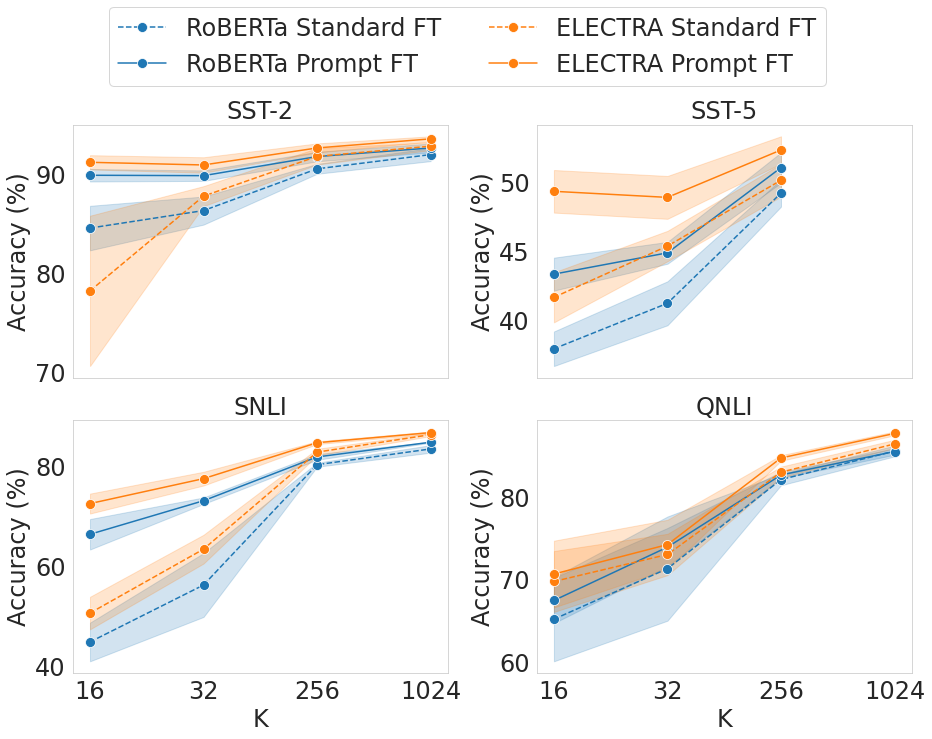

In [22]:
sns.set_style("whitegrid", {'axes.grid' : False})
selected_tasks = ["sst2", "sst5", "snli", "qnli"]
# selected_tasks = ["boolq", "rte", "agnews", "mr"]
fig, axes = plt.subplots(2, 2, figsize=(13, 9), sharex=True)
for i in range(len(selected_tasks)):
    row = i // 2
    column = i % 2
    ax = axes[row][column]
    pplot(data, selected_tasks[i], ax)
fig.tight_layout(pad=0.8)
#legend
ax1 = axes[0][0]
lines_labels = [ax1.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
leg = fig.legend(lines, labels,  ncol=2, loc="upper center", fontsize=24, bbox_to_anchor=(0.5, 0.5, 0, 0.65))

plt.savefig("images/kplot.pdf", bbox_inches='tight')

In [47]:
data[data["task"]]

,task,k,model,training type,dev,std


In [140]:
task_data[(task_data["model"] == "roberta") & (task_data["training type"] == "prompt_FT")]

,task,k,model,training type,k_dev,dev
3,sst2,16,roberta,prompt_FT,0.9688,0.8922
9,sst2,32,roberta,prompt_FT,0.9219,0.8670
15,sst2,256,roberta,prompt_FT,0.9062,0.9106
21,sst2,1024,roberta,prompt_FT,0.9116,0.9300


In [74]:
{'sst2': 0, 'sst5': 1, 'snli': 22, 'mnli': 8, 'rte': 12, 'qnli': 7, 'ag_news': 31, 'boolq': 23, 'mr': 4, 'imdb': 2}

{'sst2': 0,
 'sst5': 1,
 'snli': 22,
 'mnli': 8,
 'rte': 12,
 'qnli': 7,
 'ag_news': 31,
 'boolq': 23,
 'mr': 4,
 'imdb': 2}

In [76]:
np.argmax(np.array([np.nan, 1]))

0

In [78]:
~np.isnan(np.array([np.nan, 1]))

array([False,  True])

In [27]:
data["task"].unique()

array(['sst2', 'sst5', 'mr', 'imdb', 'mnli', 'qnli', 'snli', 'rte',
       'boolq', 'agnews'], dtype=object)